# Convolutional Neural Networks

## Project: Machine Learning  For Dog Breed Classification

---
## Domain Background & Problem Statement

**Domain Background**

Innovative applications have appeared in various domains, such as in healthcare. In 2017, deep convolutional neural networks (CNN) were used for detection of skin cancer with dermatologist-level accuracy. The application wasn’t restricted to CNN application. Neural networks have since been used in healthcare diagnosis and administrative decision making. 
 
Since that healthcare problem is “solved” barring the obstacles of regulation, we do have one that is quite similar, yet more fun: dog breed classification! We seek to classify pictures of dogs into one of 133 dog breeds in our data. This problem is less abstract than classifying skin lesions, but can have practical application at a veterinary office, provide useful learnings, or a fun application (which is our intent). This paper is not one to be nominated for a Nobel prize, but can be applied to thousands of similar problems in different domains, that perhaps collectively aid mankind. 

**Problem Statement**

The aim is to accurately detect a dog in an image and predict the breed of that dog, based on 133 classes. This is accomplished in three parts – separate algorithms that determine whether (1) a dog is in an image (2) or a human is in an image and (3) what dog breed is predicted for the image.  Our main focus will be on (3).

<div>
<img src="images/sample_dog_output.png" width="250"/ align = "left">
</div>

# Project Layout

We break the notebook into separate steps. These links navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch, Benchmark model)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning with VGG16 and SqueezeNet)
    * [Model 1](#step4_VGG):  VGG16 transfer learning model
    * [Model 2](#step4_SqueezeNet):  SqueezeNet transfer learning model
    * [Model 3](#step4_MobileNet):  MobileNet transfer learning model    
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

### Our Brave Test Dog
Going Where No Dog Has Gone Before (used for experimenting later and discussion)

In [1]:
img_path = 'images/RandomImages/test_dog.jpg' # test image of the dog on the rug

<div>
<img src="images/RandomImages/test_dog.jpg" width="500"/>
</div>

---
<a id='step0'></a>
## Step 0: Import Datasets

Downloading and unpacking the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["axes.grid"] = False
%matplotlib inline   

import os
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


## Exploratory Data Analysis

The following shows the diversity within each image. Most images are of center, with some containing more than one dog. 

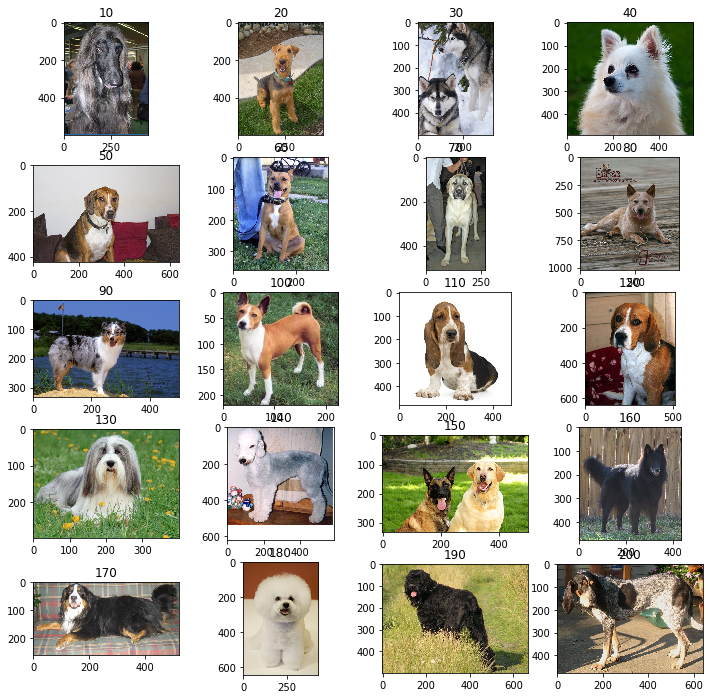

In [3]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

w=40
h=20
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = Image.open(dog_files[i*10])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(i*10)
plt.show()

Examining just a few images there are some important elements to note. From left to right there are many differences, (1) has text in the image, (2) the image is at an angle and just the face, (3) has two dogs, and (4) has plants in the foreground, with many puppies, I think. So in examining just a few images, we find there is considerable variation in the “framing” of the image and what is in it, not just the dog breed.

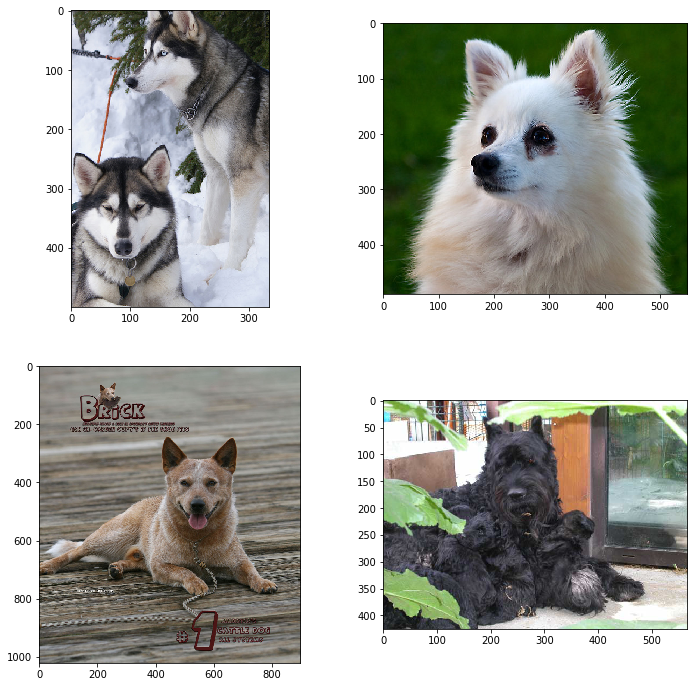

In [4]:
w=40
h=20
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 2
ims = [30,40,80,240]
for i in range(1, columns*rows+1):
    img = Image.open(dog_files[ims[i-1]])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Analyzing the dataset of dog images.

In [5]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2     

width = []
height = []
channels = []

for i in range(len(dog_files)):
    img = cv2.imread(dog_files[i])
    dimensions = img.shape
    width.append(dimensions[0])
    height.append(dimensions[1])
    channels.append(dimensions[2])

The following shows the range of input images in our data that we will use to train, validate, and test the model. All images are three channels, which indicates RGB. The "width" dimension has an average of 529 pixels and "height" dimension of 567 pixels. However, statistically speaking, there is a lot of variation in the data, with standard deviation of 333 and 389 pixels, respectively. So, what does this mean to us? Some images have more information than others. Preprocessing steps may affect some images differently.

In [6]:
df = pd.DataFrame(list(zip(width, height, channels)), columns = ['Width (pixels)', 'Height (pixels)','Channels (RGB)'])
df.describe()

,Width (pixels),Height (pixels),Channels (RGB)
count,8351.000000,8351.000000,8351.0
mean,529.044905,567.032571,3.0
std,333.197594,389.006647,0.0
min,113.000000,105.000000,3.0
25%,360.000000,375.000000,3.0
50%,467.000000,500.000000,3.0
75%,600.000000,640.000000,3.0
max,4003.000000,4278.000000,3.0


The below boxplots visually show the distribution above, with statistical outliers. However, in this case, it is fine since they are just larger images which we will resize. This does show a fair amount of variation in both the pixel width and height.

Text(0.5, 1.0, 'Boxplot: Width of Dog Images (pixels)')

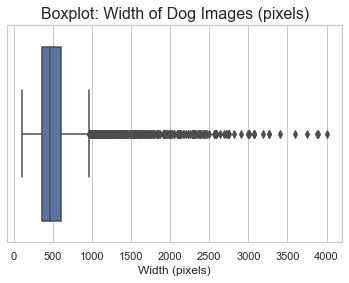

In [7]:
sns.set(style="whitegrid")
ax = sns.boxplot(df['Width (pixels)'])
plt.title('Boxplot: Width of Dog Images (pixels)', fontsize = 16)

Text(0.5, 1.0, 'Boxplot: Height of Dog Images (pixels)')

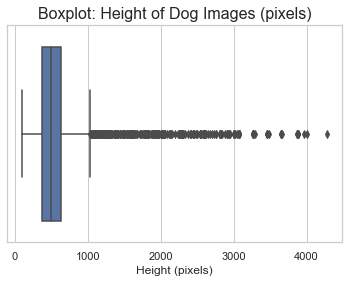

In [8]:
ax = sns.boxplot(df['Height (pixels)'])
plt.title('Boxplot: Height of Dog Images (pixels)', fontsize = 16)

Analyzing the image set of human faces, we find that all images are RGB images of the same size 250x250. On initial inspection, they appear a bit cleaner. However, we do see the same rotation, and multiple people in the same image.

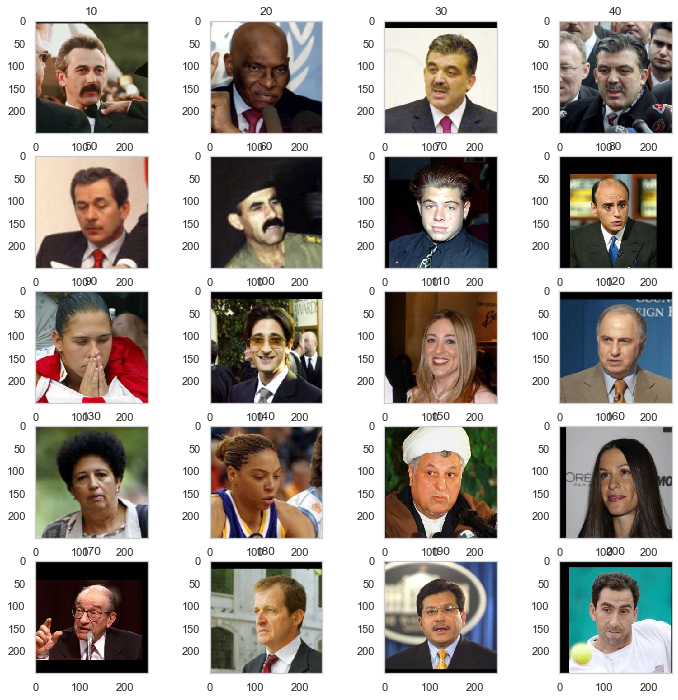

In [9]:
plt.rcParams["axes.grid"] = False

w=40
h=20
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = Image.open(human_files[i*10])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(i*10)
plt.show()

In [10]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2     

width = []
height = []
channels = []

for i in range(len(human_files)):
    img = cv2.imread(human_files[i])
    dimensions = img.shape
    width.append(dimensions[0])
    height.append(dimensions[1])
    channels.append(dimensions[2])
df_humans = pd.DataFrame(list(zip(width, height, channels)), columns = ['Width (pixels)', 'Height (pixels)','Channels (RGB)'])
df_humans.describe()

,Width (pixels),Height (pixels),Channels (RGB)
count,13233.0,13233.0,13233.0
mean,250.0,250.0,3.0
std,0.0,0.0,0.0
min,250.0,250.0,3.0
25%,250.0,250.0,3.0
50%,250.0,250.0,3.0
75%,250.0,250.0,3.0
max,250.0,250.0,3.0


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


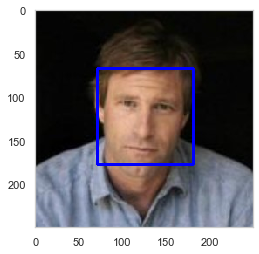

In [11]:
import cv2                            

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Writing a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [12]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

##  Assessing the Human Face Detector

## __Question 1:__ 
Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
See printed results.

In [13]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#What percentage of the first 100 images in human_files have a detected human face?
beg = 0
for i in range(len(human_files_short)):
    if face_detector(human_files_short[i]):
        beg +=1
print("The percent of human faces correct is {}%".format(beg*100/len(human_files_short)))

#What percentage of the first 100 images in dog_files have a detected human face?

beg = 0
for i in range(len(dog_files_short)):
    if face_detector(dog_files_short[i]):
        beg +=1
print("The percent of dog faces incorrectly selected as human faces is {}%".format(beg*100/len(dog_files_short)))

The percent of human faces correct is 96.0%
The percent of dog faces incorrectly selected as human faces is 18.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [14]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
use_cuda = False # this GPU does not have much computing power, so staying on CPU

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with the Pre-trained VGG-16 Model

In the next code cell, we have a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Based on [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

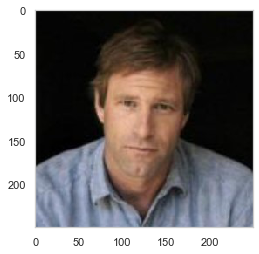

In [15]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

im = Image.open(human_files[0])
plt.imshow(im)

In [16]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to predicted ImageNet class for image at specified path
    Args: img_path: path to an image
    Returns: Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    ## Loading the image and pre-process an image from the given img_path
    img_loaded = Image.open(img_path)
    
    ## Per documentation: pre-trained models expect input images normalized in the same way, 
    ## i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are 
    ## expected to be at least 224.The images have to be loaded in to a range of [0, 1] 
    ## and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 

    data_transform_pipe = transforms.Compose([transforms.RandomResizedCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229, 0.224, 0.225])])

    img = data_transform_pipe(img_loaded) # using pipeline on image
    img = img.unsqueeze(0) #required format
    img = Variable(img) # convert to variable
    
    if use_cuda:
        img = img.cuda()
    
    prediction = VGG16(img)
    
    if use_cuda:
        prediction = prediction.data.argmax()
    else:
        prediction = prediction.data.numpy().argmax() # index of the class label with the highest value
    
    return prediction  # predicted class index

In [17]:
VGG16_predict(human_files[3]) # test prediction

906

### Obtaining the appropriate labels

In [18]:
#getting the labels 
import io
import requests

# Class labels used when training VGG as json, courtesy of the 'Example code' link above.
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'

# Let's get our class labels.
response = requests.get(LABELS_URL)  # Make an HTTP GET request and store the response.
labels = {int(key): value for key, value in response.json().items()}

print("Some example labels of dog classes; object is a dictionary")
print(labels[152])
print(labels[153])
print(labels[190])

Some example labels of dog classes; object is a dictionary
Japanese spaniel
Maltese dog, Maltese terrier, Maltese
Sealyham terrier, Sealyham


### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas, we have a function `dog_detector`, which returns `True` if a dog is detected in an image (and `False` if not).

In [19]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    new_label = VGG16_predict(img_path)
    if new_label >= 151 and new_label <=268:
        x =True
    else:
        x = False
    return x # true/false

In [20]:
dog_detector(dog_files[3]) #test should be True

True

## Assessing the Dog Detector (VGG16)

## __Question 2:__ 
Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ See below output.


In [21]:
### Test the performance of the dog_detector function on the images in human_files_short and dog_files_short.

from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#What percentage of the images in human_files_short have a detected dog?
beg = 0
for i in range(len(human_files_short)):
    if dog_detector(human_files_short[i]):
        beg +=1
print("The percent of human faces incorrectly detected as dogs is {}%".format(beg*100/len(human_files_short)))

#What percentage of the images in dog_files_short have a detected dog?
beg = 0
for i in range(len(dog_files_short)):
    if dog_detector(dog_files_short[i]):
        beg +=1
print("The percent of dog faces correctly detected as dogs is {}%".format(beg*100/len(dog_files_short)))

The percent of human faces incorrectly detected as dogs is 1.0%
The percent of dog faces correctly detected as dogs is 95.0%


## SqueezeNet DogDetector (for use in deployment)

Since using VGG-16 will be difficult to deploy due to its size, we train a pretrained SqueezeNet model. The performance is slightly better than VGG-16 but is much smaller. This will allow for easier/faster deployment with similar performance for detecting dogs.

In [22]:
squeeze_model = models.squeezenet1_0(pretrained=True)
    
def Squeeznet_predict(img_path):
    '''Use pre-trained squeezenet model to obtain index corresponding to predicted ImageNet class for image at specified path
    Args:img_path: path to an image
    Returns:Index corresponding to VGG-16 model's prediction
    '''
    
    ## Loading the image and pre-process an image from the given img_path
    img_loaded = Image.open(img_path)
    
    ## Per documentation trasformation/normalization: https://pytorch.org/hub/pytorch_vision_squeezenet/
    data_transform_pipe = transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229, 0.224, 0.225])])

    img = data_transform_pipe(img_loaded) # using pipeline on image
    img = img.unsqueeze(0) #required format
    img = Variable(img) # convert to variable
    
    if use_cuda:
        img = img.cuda()
    
    prediction = squeeze_model(img)
    
    if use_cuda:
        prediction = prediction.data.argmax()
    else:
        prediction = prediction.data.numpy().argmax() # index of the class label with the highest value
    
    return prediction  # predicted class index


### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    new_label = Squeeznet_predict(img_path)
    if new_label >= 151 and new_label <=268:
        x =True
    else:
        x = False
    return x # true/false

dog_detector(dog_files[3]) #quick test

True

### Assessing the Dog Detector (SqueezeNet1.0)

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ See below output.

In [23]:
### Test the performance of the dog_detector function on the images in human_files_short and dog_files_short.

from tqdm import tqdm

human_files_short = human_files[:200]
dog_files_short = dog_files[:200]

#What percentage of the images in human_files_short have a detected dog?
beg = 0
for i in range(len(human_files_short)):
    if dog_detector(human_files_short[i]):
        beg +=1
print("The percent of human faces incorrectly detected as dogs is {}%".format(beg*100/len(human_files_short)))

#What percentage of the images in dog_files_short have a detected dog?
beg = 0
for i in range(len(dog_files_short)):
    if dog_detector(dog_files_short[i]):
        beg +=1
print("The percent of dog faces correctly detected as dogs is {}%".format(beg*100/len(dog_files_short)))

The percent of human faces incorrectly detected as dogs is 0.5%
The percent of dog faces correctly detected as dogs is 96.5%


The SqueezeNet pre-trained model is outperforming VGG-16 on this subset. The below code saves the model to be used in deployment or load in the application directly. (The helper functions squeezenet_predict and dog_detector will be used as well, in code in the application.)

In [24]:
#format timestamp %Y%m%d%H%M%S

from datetime import datetime

model_name = 'model' + '_dog_detector_' +'_SqueezeNet_' + datetime.now().strftime('%Y%m%d%H%M%S') +'.pwf'
model_path = 'models/'+ model_name

torch.save(squeeze_model.state_dict(), model_path) # dictionary version
#torch.save(squeeze_model, model_path) # the entire model (easier deployment since not need torchvision models module)

---
<a id='step3'></a>
## Step 3: Creating a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we create a CNN that classifies dog breeds.  We create our baseline CNN _from scratch_ (no transfer learning yet), that must attain a test accuracy of at least 10%.  In Step 4 of this notebook, we use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  



### Specify Data Loaders for the Dog Dataset

We use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  

Useful documentation [here](http://pytorch.org/docs/stable/torchvision/datasets.html). We are augmenting our training and validation data using transforms, utilizing this resource [here](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform).

In [25]:
import os
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

### data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_dir = 'dogImages/train'
valid_dir = 'dogImages/valid'
test_dir  = 'dogImages/test'

num_workers = 0 #number of subprocesses to use for data loading
batch_size = 20 #how many samples per batch to load

# Creating the transform pipeline #https://pytorch.org/docs/stable/torchvision/transforms.html
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(degrees=20),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Getting images from directories and applying the transform pipeline
train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir,  transform=transform)

#define samplers for obtaining the training and validation batches
train_idx = list(range(len(train_data)))
np.random.shuffle(train_idx)
valid_idx = list(range(len(valid_data)))
np.random.shuffle(valid_idx)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders 
train_loader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = batch_size, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, sampler = valid_sampler, batch_size = batch_size, num_workers = num_workers)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size = batch_size, num_workers = num_workers)

# Specifying loaders_scratch for model below
loaders_scratch = {'train':train_loader,'valid':valid_loader,'test':test_loader} #dictioanry of loaders

## **Question 3:** 
Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: 

The code was resized to 256x256x3, and the center cropped to 224x224x3 (Most images are centered on the dog). I chose this to maintain the image quality, while not being too large (time consuming to train and predict, i.e. computationally taxing), since 32x32  may limit what can be learned (less information). Also results showed better outcomes with a larger image size, than with an initial 32x32x3 input. 

Other transformations included random horizantle flips (horizantle flips made sense while vertical would not) and normalizations. This is said to improve training by being within [0,1]. Each dataset (train,validation, & test) has an appropriate data loader. Random rotations were used as well since a lot of the images had "tilted dog faces", which may help with the variation. On the contrary, translation might be beneficial as well, but not included in this augmentation step.

### Model Architecture

Here we are creating the "scratch" CNN to classify dog breed. 

In [26]:
import torch.nn as nn

# define the CNN architecture, setting up sequentially rather than functional
       
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()    
                
        # Declaring feature extraction layers
        self.features = nn.Sequential(nn.Conv2d(3,16,3, padding = 1), nn.ReLU(inplace=True), nn.MaxPool2d(2,2),
                                      nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                      nn.Conv2d(16,32,3,padding = 1), nn.ReLU(inplace=True), nn.MaxPool2d(2,2),
                                      nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                      nn.Conv2d(32,64,3, padding = 1),nn.ReLU(inplace=True), nn.MaxPool2d(2,2),
                                      nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                      nn.Conv2d(64,128,3, padding = 1), nn.ReLU(inplace=True), nn.MaxPool2d(2,2),
                                      nn.BatchNorm2d(num_features=128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                      nn.Conv2d(128,256,3, padding = 1), nn.ReLU(inplace=True), nn.MaxPool2d(2,2),
                                      nn.BatchNorm2d(num_features=256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)                                  
                                     )
        
        # declaring classification layers
        self.classifier = nn.Sequential(nn.Dropout(0.25), nn.Linear(256*7*7,500), nn.ReLU(inplace=True), 
                                        nn.Dropout(0.25), nn.Linear(500,133)
                                       )
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,256*7*7) #flatten so go in fully connected layer, max pooling 224/2/2/2/2/2 so 7x7
        x = self.classifier(x)
        return x
        
# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [27]:
print(model_scratch)

Net(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2,

## __Question 4:__ 
Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I started with a basic design, and 3x32x32 input tensor, after ~10 epochs the accuracy was low at 1%, no better than chance. Additional 128-depth convolutional layer was added, which with 50 epochs, brought the test accuracy to 2%, so clearly more layers needed.

Also, I reasoned that such a small image may not contain enough information to discern the features needed to classify different breeds. As a result, I increased the size to 3x224x224 (in various models, it also worked well such as VGG16). Five CNN layers were created with 256 channels, and limited to this amount since the reducing size was 7x7. 

Following this approach I saw an improvement, reaching 10% accuracy with 10 epochs and a learning rate of .001. I researched other ways to improve the model, and saw that batch normalization between layers proved useful in keeping the original distribution, which upon implementation, at 40 epochs, the model was at 18%. Lastly, the model still had not converged yet, so I ran for 100 epochs acheiving an accuracy of 26% on the validation set. This model is smaller, but does not perform as well as the transfer-learning model in the following steps. 

Dropout layers were included to avoid overfitting as in most models, and I increased the depth, extracting more features, and with it higher accuracy. Padding is included to avoid loss of information in the convolutions. Lastly, a fully connected layer with 133 nodes was used for the 133 dog classes. (see the github commit history for additional information)

### Specify Loss Function and Optimizer

We specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html). We save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [28]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.001)

### Train and Validate the Model

The below code trains and validates the model.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [29]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path = 'model_scratch.pt'):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    train_losses, valid_losses = [], []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()                  # clearing gradients
            output = model(data)                   # forward pass computing predicted outputs
            loss = criterion(output,target)        # calculate batch loss
            loss.backward()                        # backward pass - computing gradient
            optimizer.step()                       # optimization step updating parameters
            train_loss += loss.item() * batch_size # running train loss per pytorch docs
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)            # forward pass computing predicted outputs by passing inputs
            loss = criterion(output,target) # calculating batch loss
            valid_loss += loss.item() * batch_size  # running test loss
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss) 
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss lower ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path) #save
            valid_loss_min = valid_loss #update min
    # return trained model
    return model

Added the module time to track the training time (on PC, not GPU). The following trains the model_scrath for the noted epochs.

In [30]:
import time #timing 
t0 =time.time()

# train the model, set to 12 epochs, used 100 reached 26% accuracy
model_scratch = train(12, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

t1 =time.time()
Minutes = (t1-t0)/60 
print("{} minutes to run".format(Minutes)) #return timing

Epoch: 1 	Training Loss: 32564.770298 	Validation Loss: 4022.565575
Validation loss lower (inf --> 4022.565575).  Saving model ...
Epoch: 2 	Training Loss: 31467.843304 	Validation Loss: 3891.962652
Validation loss lower (4022.565575 --> 3891.962652).  Saving model ...
Epoch: 3 	Training Loss: 30378.573589 	Validation Loss: 3789.111500
Validation loss lower (3891.962652 --> 3789.111500).  Saving model ...
Epoch: 4 	Training Loss: 29487.849550 	Validation Loss: 3703.949022
Validation loss lower (3789.111500 --> 3703.949022).  Saving model ...
Epoch: 5 	Training Loss: 28704.874935 	Validation Loss: 3639.540906
Validation loss lower (3703.949022 --> 3639.540906).  Saving model ...
Epoch: 6 	Training Loss: 28014.090891 	Validation Loss: 3567.057467
Validation loss lower (3639.540906 --> 3567.057467).  Saving model ...
Epoch: 7 	Training Loss: 27453.183761 	Validation Loss: 3518.951602
Validation loss lower (3567.057467 --> 3518.951602).  Saving model ...
Epoch: 8 	Training Loss: 26922.4104

### Test the Model

We try out the model on the test dataset of dog images.  We use the code cell below to calculate and print the test loss and accuracy.  Since this is our benchmark model, it must have greater accuracy is greater than 10%.

In [31]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    test_losses = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        test_loss += loss.item() * batch_size # running test loss
        
        test_losses.append(test_loss)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label, accuracy
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [32]:
# calling test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda) 

Test Loss: 3278.997335


Test Accuracy: 12% (106/836)


Test accuracy in1 12 epochs is 12%, and has not yet converged based on the continuing decline of the loss for both the training and validation set. When trained 100 epochs, accuracy was approximately 26%. (see git commit history)

### Saving the Model Artifacts via Pytorch Recommended  
See the documentation [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [33]:
#format timestamp %Y%m%d%H%M%S

from datetime import datetime

model_name = 'model' + '_CNN' +'_Scratch_Transfer_' + datetime.now().strftime('%Y%m%d%H%M%S') +'.pwf'
model_name2 = 'model_dict' + '_CNN' +'_Scratch_Transfer_' + datetime.now().strftime('%Y%m%d%H%M%S') +'.pwf'
model_path = 'models/'+ model_name
model_path2 = 'models/'+ model_name2
model_path2

#note this is saving model_scratch
torch.save(model_scratch, model_path) # #full pickle version
torch.save(model_scratch.state_dict(), model_path2) # dictionary version

C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj._

---
<a id='step4'></a>
## Step 4: Creating a CNN to Classify Dog Breeds (using Transfer Learning)

We now use transfer learning to create a CNN that can identify dog breed from images.  The CNN must attain at least 60% accuracy on the test set per project guidelines. However, due to the iterative nature of this process, and the need for date/naming conventions, multiple models and names are created. Each model is tested on the dataset of dog images, and accuracy is quantified.

###  Specifying Data Loaders for the Dog Dataset

We use the code cell below for three separate data loaders for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). [Documentation here.](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader)

<a id='step4_VGG'></a>
## VGG16 Model

**VGG16**: Specifying Data Loaders and Transformations

In [34]:
train_dir = 'dogImages/train'
valid_dir = 'dogImages/valid'
test_dir  = 'dogImages/test'

num_workers = 0 #number of subprocesses to use for data loading
batch_size = 20 #how many samples per batch to load

# Creating the transform pipeline Used on VGG16
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(degrees=20),
                                transforms.ToTensor()])
                                
# Getting images from directories and applying the transform pipeline
train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir,  transform=transform)

#define samplers for obtaining the training and validation batches
train_idx = list(range(len(train_data)))
np.random.shuffle(train_idx)
valid_idx = list(range(len(valid_data)))
np.random.shuffle(valid_idx)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders 
train_loader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = batch_size, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, sampler = valid_sampler, batch_size = batch_size, num_workers = num_workers)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size = batch_size, num_workers = num_workers)

# Specifying loaders_scratch for model below
loaders_transfer = {'train':train_loader,'valid':valid_loader,'test':test_loader} #dictioanry of loaders

**VGG16**: loading the pretrained model

In [35]:
#VGG16
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.vgg16(pretrained = True)

print(model_transfer.classifier[6].in_features) #vgg16 only
print(model_transfer.classifier[6].out_features) # vgg16 only

4096
1000


**VGG16**: Freezing inital layers, and unfreezing classifying layers

In [36]:
#freeze weights in the feature layers, act as a fixed feature extractor
for param in model_transfer.features.parameters():
    param.require_grad = False #setting this to false freezing weights at the pretrained values

# Inputs and defining the last layer
n_inputs = model_transfer.classifier[6].in_features #getting input dimensions from frozen previous layer

last_layer = nn.Linear(n_inputs, 133)
model_transfer.classifier[6] = last_layer #redefining the last layer that require_grad =True will change 

print(model_transfer.classifier[6].out_features)

133


In [37]:
# VGG16
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**VGG16**: Defining loss function and optimizer

In [38]:
# VGG16
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr = 0.01)

**VGG16**: Training the model, and saving as model_transfer

In [39]:
# VGG16
# train the model
n_epochs = 2 #only 2 here for display, but for 10 was main test (see commit history, best model loaded lower by name)
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))


Epoch: 1 	Training Loss: 18139.637158 	Validation Loss: 1364.742429
Validation loss lower (inf --> 1364.742429).  Saving model ...
Epoch: 2 	Training Loss: 10014.066169 	Validation Loss: 1112.970997
Validation loss lower (1364.742429 --> 1112.970997).  Saving model ...


<All keys matched successfully>

**VGG16**: Saving the model as pytorch artifacts with unique name/date.

In [40]:
#format timestamp %Y%m%d%H%M%S

from datetime import datetime

model_name = 'model' + '_VGG16_CNN' +'_Transfer_' + datetime.now().strftime('%Y%m%d%H%M%S') +'.pwf'
model_name2 = 'model_dict' + '_VGG16_CNN' +'_Transfer_' + datetime.now().strftime('%Y%m%d%H%M%S') +'.pwf'
model_path = 'models/'+ model_name
model_path2 = 'models/'+ model_name2
model_path

torch.save(model_transfer, model_path) # #full pickle version
torch.save(model_transfer.state_dict(), model_path2) # dictionary version

C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type VGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AdaptiveAvgPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


**VGG16**: Evaluating the model using the test function (defined in the scratch model)

In [41]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda) #function defined in the scratch model

Test Loss: 1090.456529


Test Accuracy: 61% (517/836)


In [42]:
best_VGG16 = 'model_VGG16_CNN_Transfer_20191211092843.pwf' #VGG 16 best
model_transfer = torch.load(os.path.join('models',best_VGG16))
model_transfer.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [43]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda) #function defined in the scratch model

Test Loss: 1289.749456


Test Accuracy: 57% (484/836)


<a id='step4_SqueezeNet'></a>
## SqueezeNet1.0 Model

**SqueezeNet**: Specifying Data Loaders and Transformations

In [44]:
train_dir = 'dogImages/train'
valid_dir = 'dogImages/valid'
test_dir  = 'dogImages/test'

num_workers = 0 #number of subprocesses to use for data loading
batch_size = 20 #how many samples per batch to load

transform = transforms.Compose([transforms.Resize(256), 
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(degrees=20),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                                
# Getting images from directories and applying the transform pipeline
train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir,  transform=transform)

#define samplers for obtaining the training and validation batches
train_idx = list(range(len(train_data)))
np.random.shuffle(train_idx)
valid_idx = list(range(len(valid_data)))
np.random.shuffle(valid_idx)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders 
train_loader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = batch_size, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, sampler = valid_sampler, batch_size = batch_size, num_workers = num_workers)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size = batch_size, num_workers = num_workers)

# Specifying loaders_scratch for model below
loaders_transfer = {'train':train_loader,'valid':valid_loader,'test':test_loader} #dictioanry of loaders

**SqueezeNet**: loading the pretrained model

In [45]:
# Squeezenet_1

import torchvision.models as models
import torch.nn as nn

# Specify model architecture 
model_transfer = models.squeezenet1_0(pretrained = True)

**SqueezeNet**: Freezing inital layers, and unfreezing classifying layers. Used this [documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

In [46]:
#freeze weights in the feature layers, act as a fixed feature extractor
for param in model_transfer.features.parameters():
    param.require_grad = False #setting this to false freezing weights at the pretrained values

num_classes = 133
model_transfer.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
#used this documentation https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [47]:
print(model_transfer)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

**SqueezeNet**: Defining loss function and optimizer

In [48]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr = 0.01) #used faster learning rate 

**SqueezeNet**: Training the model, and saving as model_transfer

In [49]:
# train the model
n_epochs = 1 #default is 10 for best model, 1 here for display 
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 22849.119594 	Validation Loss: 1910.032511
Validation loss lower (inf --> 1910.032511).  Saving model ...


<All keys matched successfully>

**SqueezeNet**: Saving the model as pytorch artifacts with unique name/date.

In [50]:
#format timestamp %Y%m%d%H%M%S

from datetime import datetime

model_name = 'model' + '_SqueezeNet_CNN' +'_Transfer_' + datetime.now().strftime('%Y%m%d%H%M%S') +'.pwf'
model_name2 = 'model_dict' + '_SqueezeNet_CNN' +'_Transfer_' + datetime.now().strftime('%Y%m%d%H%M%S') +'.pwf'
model_path = 'models/'+ model_name
model_path2 = 'models/'+ model_name2
model_path

torch.save(model_transfer, model_path) # #full pickle version
torch.save(model_transfer.state_dict(), model_path2) # dictionary version

C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SqueezeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Fire. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


**SqueezeNet**: Evaluating the model using the test function (defined in the scratch model)

In [51]:
best_squeeze = 'model_Squeezenet_CNN_Transfer_20191212081002.pwf' #squeezenet best
model_transfer = torch.load(os.path.join('models',best_squeeze))
model_transfer.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [52]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda) #function defined in the scratch model

Test Loss: 1420.783660


Test Accuracy: 57% (484/836)


<a id='step4_MobileNet'></a>
## MobileNetV2 Model

**MobileNet**: Specifying Data Loaders and Transformations

In [53]:
train_dir = 'dogImages/train'
valid_dir = 'dogImages/valid'
test_dir  = 'dogImages/test'

num_workers = 0 #number of subprocesses to use for data loading
batch_size = 20 #how many samples per batch to load

transform = transforms.Compose([transforms.Resize(256), 
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                                
# Getting images from directories and applying the transform pipeline
train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir,  transform=transform)

#define samplers for obtaining the training and validation batches
train_idx = list(range(len(train_data)))
np.random.shuffle(train_idx)
valid_idx = list(range(len(valid_data)))
np.random.shuffle(valid_idx)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders 
train_loader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = batch_size, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, sampler = valid_sampler, batch_size = batch_size, num_workers = num_workers)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size = batch_size, num_workers = num_workers)

# Specifying loaders_scratch for model below
loaders_transfer = {'train':train_loader,'valid':valid_loader,'test':test_loader} #dictioanry of loaders

**MobileNet**: loading the pretrained model

In [54]:
import torchvision.models as models
import torch.nn as nn

# Specify model architecture 
model_transfer = models.mobilenet_v2(pretrained=True)

**MobileNet**: Freezing inital layers, and unfreezing classifying layers

In [55]:
#freeze weights in the feature layers, act as a fixed feature extractor
for param in model_transfer.features.parameters():
    param.require_grad = False #setting this to false freezing weights at the pretrained values

num_classes = 133
model_transfer.classifier[1] = nn.Linear(model_transfer.last_channel, num_classes)
#used this documentation https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [56]:
print(model_transfer)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

)


**MobileNet**: Defining loss function and optimizer

In [57]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr = 0.01)

**MobileNet**: Training the model, and saving as model_transfer

In [58]:
import time #timing how long to train
t0 =time.time()

# train the model
n_epochs = 1 #run 1 here for display, but nest model 10 epochs
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

t1 =time.time()
Minutes = (t1-t0)/60 
print("{} minutes to run".format(Minutes))

Epoch: 1 	Training Loss: 26254.099660 	Validation Loss: 2384.228735
Validation loss lower (inf --> 2384.228735).  Saving model ...
271.1138833204905 minutes to run


**MobileNet**: Saving the model as pytorch artifacts with unique name/date.

In [59]:
#format timestamp %Y%m%d%H%M%S

from datetime import datetime

model_name = 'model' + '_MobileNet_CNN' +'_Transfer_' + datetime.now().strftime('%Y%m%d%H%M%S') +'.pwf'
model_name2 = 'model_dict' + '_MobileNet_CNN' +'_Transfer_' + datetime.now().strftime('%Y%m%d%H%M%S') +'.pwf'
model_path = 'models/'+ model_name
model_path2 = 'models/'+ model_name2
model_path

torch.save(model_transfer, model_path) # #full pickle version
torch.save(model_transfer.state_dict(), model_path2) # dictionary version

C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MobileNetV2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvBNReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU6. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type InvertedResidual. It won't be checked for correctness upon loading

**MobileNet**:  Evaluating the model using the test function (defined in the scratch model)

In [60]:
best_mobile  = 'model_MobileNet_CNN_Transfer_20191214165656.pwf'
model_transfer = torch.load(os.path.join('models',best_mobile))
model_transfer.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [61]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda) #function defined in the scratch model

Test Loss: 573.645535


Test Accuracy: 82% (693/836)


<div>
<img src='images/MobileNetTrainingTime.jpg'/>
</div>

In [62]:
#As a note this model acheived 82% accuracy in 10 epochs, but also took 48.6 hours to train on my PC.
2914.535915696621/60 #2 full days. 

48.575598594943685

## __Question 5:__

Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I initially utilized the VGG16 architecture to be consistant with the early stages of the project. We froze all early layers, and unfroze last layer for classification into our 133 dog classes. After training the model for 100 epochs, the model maintained 57% accuracy, which is pretty good. More epochs would have resulted in higher accuracy 

However, this model is too large for operationalizing via Flask/Heroku. Unfortunately, while attempting to deploy the model to Heroku, I learned that the operational "slug" size is only allowed at 500 MB, so a different model was needed in order to operationalize the model. (It would be fine on AWS but our chosen platform is Heroku for this project). So, I needed to select architechtures that had similar performance, yet smaller size.

So, I decided to train two smaller models (1) SqueezeNet and (2) MobileNet due to the smaller model size. (As a result, the jupyter notebook has been recycled multiple times, which can be found in github under the commit history). 

- After training the model for 10 epochs, we obtained an accuracy of 57%. This model was not as good as VGG16, but would work operationally. 
- After training, MobileNetV2  resulted in higher accuracy at 82% (did train 2 full days, not GPU, much longer than either VGG16 or SqueezeNet). 

As a result, the model chosen for operationalization was MobileNetV2 due to performance, and also the ability to operationalize on Heroku. Deployment of the model was successful.

(Deploying pytorch did take a lot of space, so a smaller version was uploaded/used in the final application.)

---
<a id='step5'></a>
## Step 5: Writing Our Own Algorithm

In this section, we write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error. (Edit: and also returns an image of predicted dog.)

We use the `face_detector` and `dog_detector` functions developed above.  The __required__  CNN from Step 4 is used to predict dog breed.  

##   Predict Dog Breed with the Model

**Getting the Dog Classes & Text Cleaning**

This block of code obtains the labels actual breed name. We then Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the  model.  

In [63]:
import os
classes_dogs = os.listdir("dogImages/train/")
classes = [classes_dogs[i].split('.')[1] for i in range(len(classes_dogs))]
classes = [classes[i].replace("_", " ").title() for i in range(len(classes))]
classes[:5]

['Affenpinscher',
 'Afghan Hound',
 'Airedale Terrier',
 'Akita',
 'Alaskan Malamute']

## Top Performing Models

These are the best performing models for each of the VGG16, MobileNetV2, and SqueezeNet.

In [64]:
best_VGG16 = 'model_VGG16_CNN_Transfer_20191211092843.pwf' #VGG 16 best 57%
best_mobile  = 'model_MobileNet_CNN_Transfer_20191214165656.pwf' #mobilenetv2 best 82%
best_squeeze = 'model_Squeezenet_CNN_Transfer_20191212081002.pwf' #squeezenet best 57%

Loading the best MobileNetV2 Model 'model_MobileNet_CNN_Transfer_20191214165656.pwf'

In [65]:
model_application = torch.load(os.path.join('models',best_mobile)) 
model_application.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

### Helper Functions For Running the Application Logic

In [66]:
#using the same transformation steps

def image_loader(image_name):
    """load image, returns cuda tensor"""
    
    #defining the transformer
    transformer = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(degrees=20),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    image = Image.open(image_name)
    image = transformer(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU

def use_transfer_CNN(img_path):
    """Uses image_loader function, model_application predicts transformed image, returns the class label"""
    image = image_loader(img_path)
    output = model_application(image) #use NN
    _, preds_tensor = torch.max(output,1)
    preds = np.squeeze(preds_tensor.numpy()) #only CPU fix for GPU later
    name = classes[preds.flat[0]] #labels contains the classes
    return(name)

#when running the algorithm, it returns the text and the original photo
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path):
        output = "A dog is detected and it looks like a {}!".format(use_transfer_CNN(img_path))
        im = Image.open(img_path)
        pic = plt.imshow(im)
        return(pic, output)
    elif face_detector(img_path):
        output = "A human is detected that looks like a {}!".format(use_transfer_CNN(img_path))
        im = Image.open(img_path)
        pic = plt.imshow(im)
        return(pic, output)
    else:
        output = "No dog or human was detected. It might be an unknown multidimensional being!"
        im = Image.open(img_path)
        pic = plt.imshow(im)
        return(pic, output)
    
# This returns only the functional text output from the model_scratch (used in the application)
def run_app_text_only(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path):
        output = "It's a {}!".format(use_transfer_CNN(img_path))
        return(output)
    elif face_detector(img_path):
        output = "This human looks like a {}".format(use_transfer_CNN(img_path))
        return(output)
    else:
        output = "Unknown!"
        return(output)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, we take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

###  Testing The Algorithm on Sample Images!

We test the algorithm at least six images on your computer, an assortment of cats, dogs, and people.  

(<matplotlib.image.AxesImage at 0x21f1739be10>,
 'A human is detected that looks like a Brussels Griffon!')

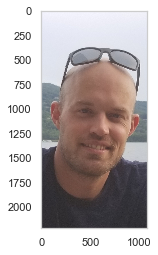

In [67]:
#testing it ( What kind of dog does the algorithm think that I look like?)
img_path = 'images/RandomImages/test_human.jpg'
run_app(img_path)

## __Question 6:__
Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The algorithm is a lot better than I expected, with some funny outputs. It gives slightly different outputs than the VGG16-based transfer model, which chose the Beagle correctly. The human and dog detection seems to fail on pictures of pictures.

Three areas for improvement are: 
- (1) improving the face_detector and dog_detector models through using custom CNNs perhaps based off transfer learning,
- (2) improving the architecture of the model_scratch through additional layers or augmentation, and 
- (3) utilizing data augmentation/larger dataset to improve the model. 
- (4) use AWS or Azure in order to operationalize the model rather than on Heroku, where size is unlikely an issue.

Running various test images through the algorithm.

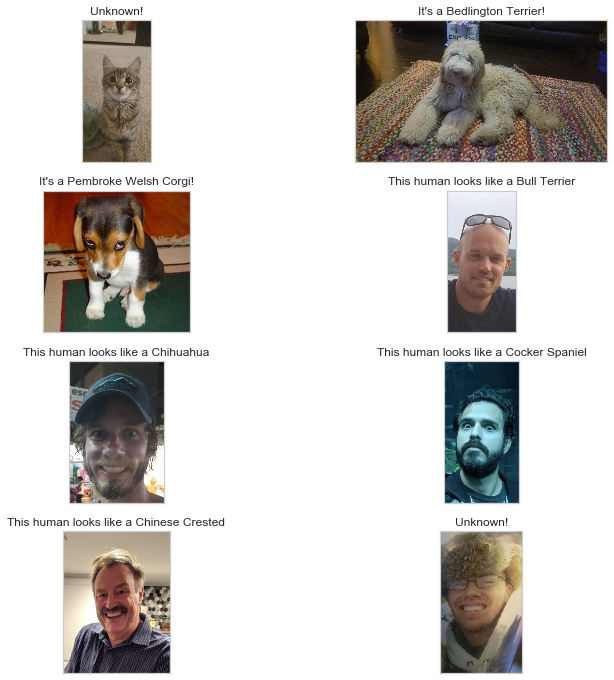

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Taking care of windows issue and getting test files
file_path = 'images/RandomImages'
random_test_list = os.listdir(file_path)
random_test_list
test_files = ['images/RandomImages' +'/'+ i for i in random_test_list] #love for windows 10
test_files

# plotting and checking using the top performing model, and returning its text output
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 4
for i in range(1, columns*rows +1):
    img = cv2.imread(test_files[i-1])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i, xticks=[],yticks=[])
    plt.imshow(cv_rgb)
    image_file_name = "{}".format(run_app_text_only(test_files[i-1]))
    plt.title(image_file_name)
plt.show()

# Final Application User Experience

A sample from the application (deployed algorithm) is provided below. However, there is a difference in the application. It returns a picture of the dog that it resembles. I think that this functionality is more fun. 

Feel free to test it out live at this [link](https://whos-a-good-boy.herokuapp.com/). The about section provides additional details. This uses a separate github repository [here](https://github.com/radleap/Application-Heroku-Dog-Class-Prediction), which was used to limit all the files that would be used on Heroku.

<div>
<img src="images/sample_phone_image.jpg" width="500"/>
</div>